# Computer Vision CSCI-GA.2272-001 Assignment 1, part 2.

Fall 2021 semester.

Due date: **September 30th 2021.**

## Introduction
This assignment requires you to participate in a Kaggle competition with the rest of the class on the The German Traffic Sign Recognition Benchmark [http://benchmark.ini.rub.de/?section=gtsrb&subsection=news]. The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the private link: https://www.kaggle.com/c/nyu-computer-vision-csci-ga2271-2021/overview.

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file gtsrb_kaggle.csv that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score. 

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
You should make a copy of this Colab (File->Save a copy in Drive). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is not allowed! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.
Your solutions should be submitted via the Brightspace system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models. 

### Important Details
• You are only allowed eight (8) submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 0.95. 

• *Extra important:* Please use your NYU NetID as your Kaggle username, so the TAs can figure out which user you are on the leaderboard. 


# Dataset Preparation


1.  Download `dataset.zip` from to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders (`training,validation,testing`). 
3.  Go to Google Drive (on your NYU account) and make a directory `assign2_dataset` (New button --> New Folder).
4.  Upload each of the three subfolders to it (New button --> Folder upload). 
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested. 


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/assign2_dataset/

Mounted at /content/drive
/content/drive/My Drive/assign2_dataset


# Dataloader

In [ ]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

batch_size = 64
momentum = 0.9
lr = 0.01
epochs = 30
log_interval = 10

class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt"):

        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Model

**Model Selection Reason**

The model incorporates concepts of the Network-In-Network model and extensive usage of batch normalization to increase computational speed.

There are 2 blocks of convolutional layers followed by 2 fully-connected layers.

Each convolutional layer is batch normalized so that the input feeding into the next convolutional layer (and when backpropagated) has lower variance. Max pooling is performed at the end of each convolutional block to reduce dimensionality. The ReLU non-linearity is used because it is the most widely used non-linearity in modern day models.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.feature_map = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 192, 3),
            nn.BatchNorm2d(192),
            nn.Conv2d(192, 96, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
            nn.BatchNorm2d(96),
            nn.Dropout(inplace=True)
        )

        self.fc1 = nn.Linear(96 * 5 * 5, 80)
        self.fc2 = nn.Linear(80, nclasses)

    def forward(self, x):
        x = self.feature_map(x)
        
        # print(x.shape)
        
        # need to flatten output before fully-connected layers as
        # they expect 1D vector as input
        x = x.view(-1, 96 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


# Training

In [ ]:
model = Net()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [ ]:
from torchsummary import summary
summary(model.cpu(), input_size=(3,32,32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
       BatchNorm2d-2           [-1, 64, 30, 30]             128
            Conv2d-3          [-1, 128, 28, 28]          73,856
              ReLU-4          [-1, 128, 28, 28]               0
         MaxPool2d-5          [-1, 128, 14, 14]               0
       BatchNorm2d-6          [-1, 128, 14, 14]             256
            Conv2d-7          [-1, 192, 12, 12]         221,376
       BatchNorm2d-8          [-1, 192, 12, 12]             384
            Conv2d-9           [-1, 96, 10, 10]         165,984
             ReLU-10           [-1, 96, 10, 10]               0
        MaxPool2d-11             [-1, 96, 5, 5]               0
      BatchNorm2d-12             [-1, 96, 5, 5]             192
          Dropout-13             [-1, 96, 5, 5]               0
           Linear-14                   

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
from torch.autograd import Variable

best_validation_accuracy = 0.0
curr_validation_accuracy = 0.0
best_epoch = 1
training_accuracy = []
validation_accuracy = []

def train(epoch):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    return 100. * correct / len(train_loader.dataset)

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return 100. * correct / len(val_loader.dataset)

for epoch in range(1, epochs + 1):
    curr_training_accuracy = train(epoch)
    curr_validation_accuracy = validation()
    
    training_accuracy.append(curr_training_accuracy)
    validation_accuracy.append(curr_validation_accuracy)
    
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')
    if curr_validation_accuracy > best_validation_accuracy:
      best_validation_accuracy = curr_validation_accuracy
      best_epoch = epoch
      print('\nMost accurate epoch so far: {}'.format(best_epoch))

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.931246
Train Epoch: 1 [640/35339 (2%)]	Loss: 3.232257
Train Epoch: 1 [1280/35339 (4%)]	Loss: 2.949193
Train Epoch: 1 [1920/35339 (5%)]	Loss: 2.310938
Train Epoch: 1 [2560/35339 (7%)]	Loss: 2.316420
Train Epoch: 1 [3200/35339 (9%)]	Loss: 1.676103
Train Epoch: 1 [3840/35339 (11%)]	Loss: 1.736788
Train Epoch: 1 [4480/35339 (13%)]	Loss: 1.754452
Train Epoch: 1 [5120/35339 (14%)]	Loss: 1.458635
Train Epoch: 1 [5760/35339 (16%)]	Loss: 1.481479
Train Epoch: 1 [6400/35339 (18%)]	Loss: 1.238352
Train Epoch: 1 [7040/35339 (20%)]	Loss: 1.110657
Train Epoch: 1 [7680/35339 (22%)]	Loss: 0.895336
Train Epoch: 1 [8320/35339 (24%)]	Loss: 0.761815
Train Epoch: 1 [8960/35339 (25%)]	Loss: 0.916237
Train Epoch: 1 [9600/35339 (27%)]	Loss: 0.800413
Train Epoch: 1 [10240/35339 (29%)]	Loss: 0.757459
Train Epoch: 1 [10880/35339 (31%)]	Loss: 0.499960
Train Epoch: 1 [11520/35339 (33%)]	Loss: 0.646698
Train Epoch: 1 [12160/35339 (34%)]	Loss: 0.646262
Train Epoch: 1 [12800/3533

#Plot training results

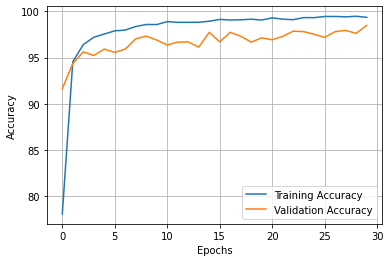

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

epoch_range = list(range(epochs))

plt.plot(epoch_range,training_accuracy)
plt.plot(epoch_range,validation_accuracy)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylabel(u'Accuracy')
plt.xlabel(u'Epochs')

plt.grid(True)
plt.show()

# Evaluate and Submit to Kaggle



In [ ]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))

model_file = 'model_' + str(best_epoch) + '.pth'
model = Net() # TODO: load your model here, don't forget to put it on Eval mode !
model.load_state_dict(torch.load(model_file))
model.eval()

for i, data in enumerate(test_data):
    data = data.unsqueeze(0)

    output = model(data)
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

Written to csv file gtsrb_kaggle.csv


# Submitting to Kaggle

Now take this csv file, download it from your Google drive and then submit it to Kaggle to check performance of your model.